# Import the Required Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import cv2
import sys
import imutils
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

sys.path.append('/content/drive/MyDrive')
from resnet import ResNet

# Data Acquisition
Here we load the datasets

In [ ]:
#Define Functions for loading Data
def load_az_dataset(datasetPath):
	data = []
	labels = []
	
	for row in open(datasetPath):
		row = row.split(",")
		label = int(row[0])
		image = np.array([int(x) for x in row[1:]], dtype="uint8")
		image = image.reshape((28, 28))
		data.append(image)
		labels.append(label)
		
	data = np.array(data, dtype="float32")
	labels = np.array(labels, dtype="int")
	return (data, labels)

def load_mnist_dataset():
	((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
	data = np.vstack([trainData, testData])
	labels = np.hstack([trainLabels, testLabels])
	return (data, labels)

#Load the datasets
(azData, azLabels) = load_az_dataset(r'/content/drive/MyDrive/A_Z Handwritten Data.csv')
(digitsData, digitsLabels) = load_mnist_dataset()

11493376/11490434 [==============================] - 0s 0us/step


# Modelling
Here we train and load the model

In [ ]:
#Combine the datasets
azLabels += 10
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

#Pre - process the dataset elements
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
data = np.expand_dims(data, axis=-1)
data /= 255.0
le = LabelBinarizer()
labels = le.fit_transform(labels)
aug = ImageDataGenerator(rotation_range=10,	zoom_range=0.05, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, horizontal_flip=False, fill_mode="nearest")

In [ ]:
#Split the dataset into training and testing
(trainX, testX, trainY, testY) = train_test_split(data,	labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
#Calculate Class Weight
classTotals = labels.sum(axis=0)
classWeight = {}

for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

In [ ]:
#Train the model
opt = SGD(learning_rate=1e-1, decay=1e-1 / 10)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3), (64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])
H = model.fit(aug.flow(trainX, trainY, batch_size=128), validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,	epochs=10, 	class_weight=classWeight, verbose=1)

In [ ]:
#Load the Model
model = load_model('/content/drive/MyDrive/handwriting.model')

# Evaluation
Here we check the performance of our model

In [ ]:
#Set the labels
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# Evaluate the model
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      1381
           1       0.97      0.98      0.97      1575
           2       0.87      0.96      0.92      1398
           3       0.98      0.99      0.99      1428
           4       0.90      0.95      0.92      1365
           5       0.87      0.88      0.88      1263
           6       0.95      0.98      0.96      1375
           7       0.96      0.99      0.97      1459
           8       0.95      0.98      0.96      1365
           9       0.96      0.98      0.97      1392
           A       0.98      0.99      0.99      2774
           B       0.98      0.98      0.98      1734
           C       0.99      0.99      0.99      4682
           D       0.95      0.95      0.95      2027
           E       0.99      0.99      0.99      2288
           F       0.99      0.96      0.97       232
           G       0.97      0.93      0.95      115

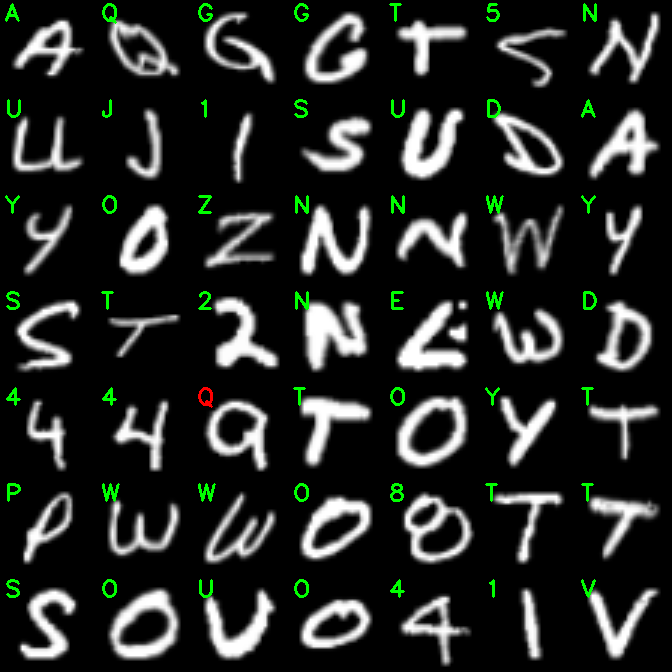

-1

In [ ]:
images = []
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]

	# Correct
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)
 
	# Incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)
	
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
	images.append(image)
 
# Show Output Grid 
montage = build_montages(images, (96, 96), (7, 7))[0]
cv2_imshow( montage)
cv2.waitKey(0)

# Application

[INFO] H - 89.15%
[INFO] E - 69.62%
[INFO] L - 98.85%
[INFO] L - 98.76%
[INFO] 0 - 24.67%
[INFO] W - 60.20%
[INFO] 2 - 38.42%
[INFO] R - 98.34%
[INFO] L - 97.95%
[INFO] D - 37.51%


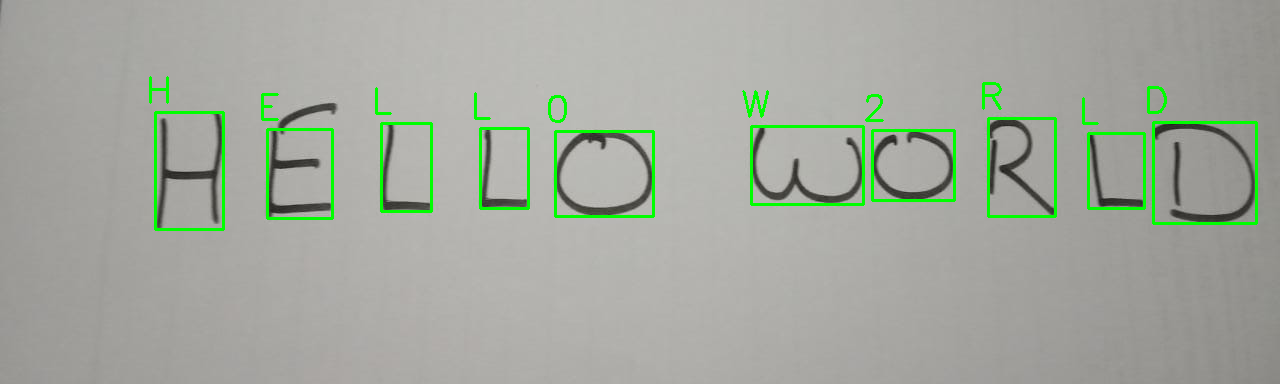

-1

In [ ]:
# Load Image
image = cv2.imread('/content/drive/MyDrive/test.jpeg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect contours and sort from left to right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

# Contour Processing
chars = []
for c in cnts:
	# Identify the bounding box of the contours
	(x, y, w, h) = cv2.boundingRect(c)
	if (w >= 20 and w <= 150) and (h >= 40 and h <= 120):
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		# Resize
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		else:
			thresh = imutils.resize(thresh, height=32)

		# Pad the Image
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		# Process Padded Image
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		chars.append((padded, (x, y, w, h)))
boxes = [b[1] for b in chars]

# Perform OCR
chars = np.array([c[0] for c in chars], dtype="float32")
preds = model.predict(chars)

# Decode Labels
labelNames = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
for (pred, (x, y, w, h)) in zip(preds, boxes):
  i = np.argmax(pred)
  prob = pred[i]
  label = labelNames[i]

	# Draw the prediction on Screen
  print("[INFO] {} - {:.2f}%".format(label, prob * 100))
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
  cv2.putText(image, label, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

# Display the Image
cv2_imshow( image)
cv2.waitKey(0)